In [56]:
## Imports
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Draw inline
%matplotlib inline

# Set figure aesthetics
plt.style.use('ggplot')
sns.set_style({'ytick.major.size': 10.0})
sns.set_context("talk", font_scale=1.0)

In [3]:
colors = ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']

In [4]:
import json
from pandas.io.json import json_normalize

data = json.load((open('G:\Datasets\StudentLife\dataset\EMA\EMA_definition.json')))

In [5]:
import os

def EMA_extractor(Question):
    
    # Set up filenames
    EMA_root_directory = r'G:\Datasets\StudentLife\dataset\EMA\response'
    foldername = os.path.join(EMA_root_directory,Question)
#    print('foldername:',foldername)
    filenames = os.listdir(foldername)
    
    # Create Initial Dataframe with first student
    student_id = filenames[0][-8:-5]
    file = os.path.join(EMA_root_directory,Question,filenames[0])

    df = pd.read_json(file)
    df['id'] = student_id


    # Iterate over the rest of students
    for filename in filenames[1:]:
        student_id = filename[-8:-5]
        file = os.path.join(EMA_root_directory,Question,filename)

        df_student = pd.read_json(file)
        df_student['id'] = student_id

        df = pd.concat([df,df_student],ignore_index=True)
    
    return df

In [152]:
start = pd.datetime(2013,4,21)
end = pd.datetime(2013,5,5)
semester_end = '2013-06-01'

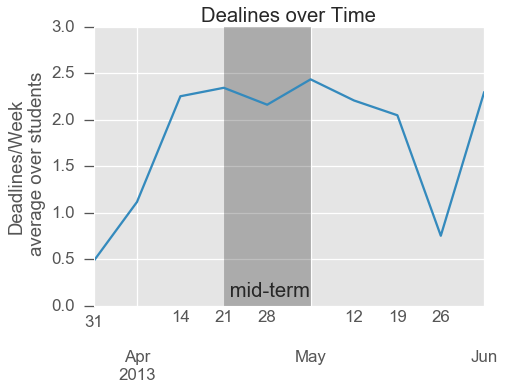

In [40]:
deadlines = pd.read_csv(r'G:\Datasets\StudentLife\dataset\education\deadlines.csv')
deadlines = deadlines.reset_index(drop=True).set_index('uid').T.reset_index()
deadlines['time'] = pd.to_datetime(deadlines['index'])
deadlines = deadlines.set_index('time').drop('index',axis=1)
D = deadlines[:'2013-06-01'].mean(axis=1).resample('W',how='sum')
x = list(D.index)

fig,ax = plt.subplots(figsize=(7,5))

D.plot(color='#348ABD')
plt.title('Dealines over Time')
plt.xlabel('')
plt.ylabel('Deadlines/Week\n average over students')

ax.fill_between([start,end],0,3,facecolor='black', alpha = .25, interpolate=True)
ax.text(start, 0.1,' mid-term')
sns.despine()

# EXERCISE MEASURES

## Gym via GPS

In [26]:
East_Edge = np.array([43.703137, -72.282336])
West_Edge = np.array([43.702605, -72.284715])
North_Edge = np.array([43.703313, -72.284062])
South_Edge = np.array([43.702314, -72.283717])

gym_radius = np.sqrt(sum((West_Edge - East_Edge)**2))/4
gym_location = np.array([43.702927, -72.284007])


In [27]:
def gps_extractor(file):
    student_id = file[-7:-4]
    
    gps = pd.read_csv(file,usecols=[0,4,5],header=0,index_col=False,parse_dates=['time'])
    gps['timestamp'] = pd.to_datetime(gps['time'].astype(int),unit='s')
    gps = gps.set_index('timestamp').drop('time',axis=1)
    gps['id'] = student_id

    return gps

In [28]:
foldername = r'G:\Datasets\StudentLife\dataset\sensing\gps'
filenames = os.listdir(foldername)

# Create Initial Dataframe with first student
file = os.path.join(foldername,filenames[0])

#Function for reading in file
df = gps_extractor(file)

# Iterate over the rest of students
for filename in filenames[1:]:
    file = os.path.join(foldername,filename)

    df_student = gps_extractor(file)
    df = pd.concat([df,df_student])

GPS_df = df 

GPS_df['gym'] = (np.sqrt(np.sum((GPS_df[['latitude','longitude']].values - gym_location)**2,axis=1))<gym_radius).astype(int)

In [47]:
GPS_df.head()

,latitude,longitude,id,gym
timestamp,,,,
2013-03-27 04:02:43,43.759135,-72.329240,u00,0
2013-03-27 04:22:24,43.759503,-72.329018,u00,0
2013-03-27 04:42:44,43.759134,-72.329238,u00,0
2013-03-27 05:02:43,43.759135,-72.329240,u00,0
2013-03-27 05:22:43,43.759135,-72.329240,u00,0


#### GPS Gym Distribution over Students

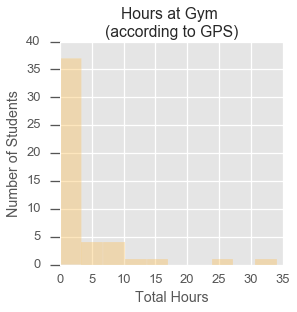

In [116]:
fig,ax = plt.subplots(figsize=(4,4))

gym_sum = GPS_df.groupby('id')['gym'].sum().sort_values(ascending=False)/6
sns.distplot(gym_sum,kde=False,color=colors[4],bins=10)

plt.title('Hours at Gym \n(according to GPS)')
plt.xlabel('Total Hours')
plt.ylabel('Number of Students')
sns.despine()

In [ ]:
A = (((GPS_df.groupby('id').resample('W',how='sum')['gym'].unstack(level=1))/6)>0.5).sum()
A.plot()
plt.title('Number of Students spending >30mins in Gym/Week')

#### GPS Gym over Time

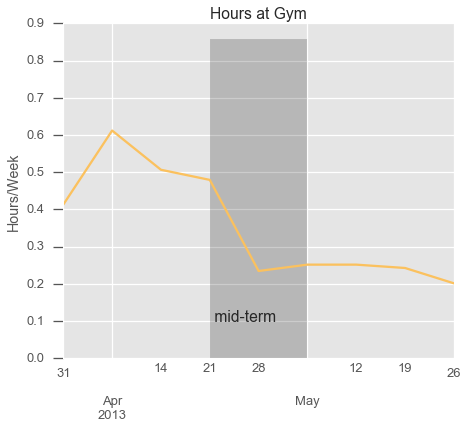

In [175]:
GymWeek = GPS_df.groupby('id').resample('W',how='sum')['gym'].unstack(level=1).mean()/6 #Divide by 6 because each point is 10 minutes

fig,ax = plt.subplots(figsize=(7,6))

GymWeek[:semester_end].plot(color=colors[4])
plt.title('Hours at Gym')
plt.xlabel('')
plt.ylabel('Hours/Week')

ax.fill_between([start,end],0,G.max()*1.4,facecolor='black', alpha = .2, interpolate=True)
ax.text(start, 0.1,' mid-term')
sns.despine()

## Exercise by Sensor Detection (time spent running)

In [65]:
def activities_5(file):
    student_id = file[-7:-4]
    
    act = pd.read_csv(file,parse_dates=['timestamp'])
    act['timestamp'] = pd.to_datetime(act['timestamp'].astype(int),unit='s')
    act.set_index('timestamp',inplace=True)
    act.rename(columns={act.columns[0]:'activity_inference'},inplace=True)
    
    act = act['activity_inference'].astype("category")
    act5 = (pd.get_dummies(act).resample('5T',how='mean')>0.5).astype(int)

    
    act5.rename(index={0:student_id},columns={0:'Stationary',1:'Walking',2:'Running',3:'Unknown'},inplace=True)
    #act_totals_percent = act_totals.divide(act_totals.sum(axis=1),axis=0)
    act5['id'] = student_id
    
    return act5

In [66]:
foldername = r'G:\Datasets\StudentLife\dataset\sensing\activity'
filenames = os.listdir(foldername)

# Create Initial Dataframe with first student
file = os.path.join(foldername,filenames[0])

#Function for reading in file
df = activities_5(file)

# Iterate over the rest of students
for filename in filenames[1:]:
    file = os.path.join(foldername,filename)

    df_student = activities_5(file)
    df = pd.concat([df,df_student])

Activity_df = df    

In [68]:
Activity_df.tail()

,Stationary,Walking,Running,Unknown,id
timestamp,,,,,
2013-06-01 03:35:00,1,0,0,0,u59
2013-06-01 03:40:00,1,0,0,0,u59
2013-06-01 03:45:00,1,0,0,0,u59
2013-06-01 03:50:00,1,0,0,0,u59
2013-06-01 03:55:00,1,0,0,0,u59


In [105]:
pd.options.display.float_format = '{:.2f}'.format


In [112]:
A = Activity_df.groupby('id').resample('W',how='sum').unstack(level=0).T.sum(axis=1)
Activity_WA = pd.DataFrame(A).unstack(level=0).T.reset_index(level=0,drop=True).T/12
Activity_WA.head()

,Running,Stationary,Unknown,Walking
id,,,,
u00,22.92,1203.50,43.17,84.00
u01,23.75,1309.75,5.92,47.17
u02,1.00,1437.17,19.08,85.83
u03,1.17,1173.42,2.58,13.33
u04,40.75,1171.50,36.75,86.83


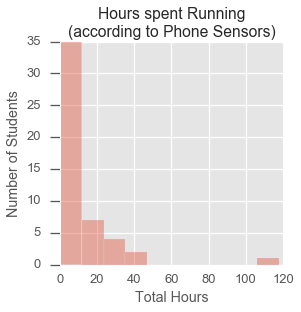

In [117]:
fig,ax = plt.subplots(figsize=(4,4))

sns.distplot(Activity_WA['Running'],kde=False,color=colors[0],bins=10)

plt.title('Hours spent Running\n(according to Phone Sensors)')
plt.xlabel('Total Hours')
plt.ylabel('Number of Students')
sns.despine()

In [78]:
Activity_df.groupby('id').sum()/12

,Stationary,Walking,Running,Unknown
id,,,,
u00,1203.5000,84.0000,22.9167,43.1667
u01,1309.7500,47.1667,23.7500,5.9167
u02,1437.1667,85.8333,1.0000,19.0833
u03,1173.4167,13.3333,1.1667,2.5833
u04,1171.5000,86.8333,40.7500,36.7500
u05,1287.1667,46.9167,2.6667,28.4167
u07,1063.6667,35.1667,12.5000,15.0000
u08,1390.3333,73.0000,18.8333,9.2500
u09,1329.8333,67.5000,6.5833,20.0833


### Hours of Running over Time

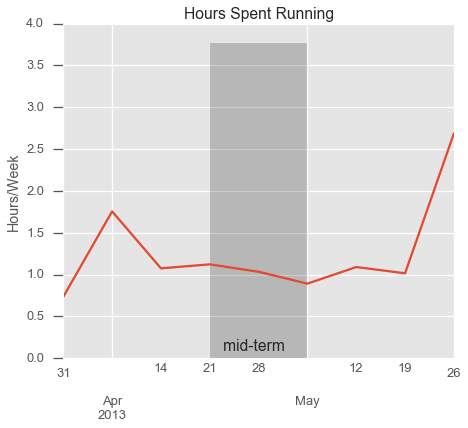

In [173]:
fig,ax = plt.subplots(figsize=(7,6))

A = Activity_df.groupby('id').resample('W',how='sum').unstack(level=0)['Running'].mean(axis=1)/12
A[:semester_end].plot(color=colors[0]);


plt.title('Hours Spent Running')
plt.xlabel('')
plt.ylabel('Hours/Week')

ax.fill_between([start,end],0,A.max()*1.4,facecolor='black', alpha = .2, interpolate=True)
ax.text(start, 0.1,'   mid-term')
sns.despine()

## Hours of Exercise by Self Report

In [131]:
import os

def EMA_extractor(Question):
    
    # Set up filenames
    EMA_root_directory = r'G:\Datasets\StudentLife\dataset\EMA\response'
    foldername = os.path.join(EMA_root_directory,Question)
#    print('foldername:',foldername)
    filenames = os.listdir(foldername)
    
    # Create Initial Dataframe with first student
    student_id = filenames[0][-8:-5]
    file = os.path.join(EMA_root_directory,Question,filenames[0])

    df = pd.read_json(file)
    df['id'] = student_id


    # Iterate over the rest of students
    for filename in filenames[1:]:
        student_id = filename[-8:-5]
        file = os.path.join(EMA_root_directory,Question,filename)

        df_student = pd.read_json(file)
        df_student['id'] = student_id

        df = pd.concat([df,df_student],ignore_index=True)
    
    return df

In [132]:
# EXERCISE
df = EMA_extractor('Exercise')

#Clean-up
Exercise_df = df
Exercise_df['have'] = Exercise_df['have'].replace('null',np.nan).astype(float)
Exercise_df['schedule'] = Exercise_df['schedule'].replace('null',np.nan).astype(float)
Exercise_df.drop('location',axis=1,inplace=True)
Exercise_df.set_index('resp_time',inplace=True)
Exercise_df = Exercise_df[:'2013-06-09']

In [133]:
Exercise_df

,exercise,have,id,schedule,walk
resp_time,,,,,
2013-04-03 03:43:26,4.00,1.00,u00,nan,2.00
2013-04-01 14:55:38,3.00,2.00,u00,1.00,2.00
2013-04-01 17:12:56,1.00,2.00,u00,1.00,1.00
2013-04-02 04:03:53,1.00,1.00,u00,nan,1.00
2013-04-04 00:28:03,1.00,2.00,u00,1.00,2.00
2013-04-04 02:03:44,1.00,2.00,u00,1.00,3.00
2013-04-06 02:19:21,1.00,2.00,u00,1.00,1.00
2013-04-05 02:39:51,4.00,1.00,u00,2.00,3.00
2013-04-05 20:37:51,4.00,1.00,u00,nan,3.00


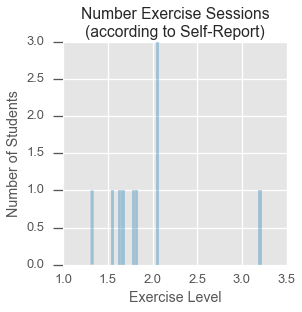

In [148]:
A = Exercise_df.groupby('id').resample('W',how='mean')['exercise'].unstack(level=1).mean(axis=0)
fig,ax = plt.subplots(figsize=(4,4))

sns.distplot(A,kde=False,bins=50,color=colors[1])

plt.title('Number Exercise Sessions\n(according to Self-Report)')
plt.xlabel('Exercise Level')
plt.ylabel('Number of Students')
sns.despine()

In [ ]:
A = Exercise_df.groupby('id').resample('W',how='mean')['Exercise']
A = A.groupby('id').resample('W',how='sum').unstack(level=1).mean(axis=1)


fig,ax = plt.subplots(figsize=(4,4))

sns.distplot(A,kde=False,bins=10,color=colors[1])

plt.title('Number Exercise Sessions\n(according to Self-Report)')
plt.xlabel('Sessions per Week')
plt.ylabel('Number of Students')
sns.despine()

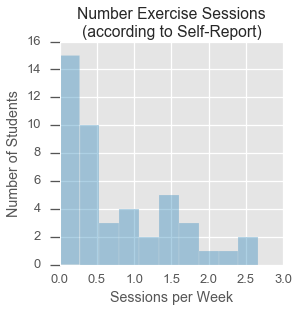

In [149]:
A = pd.DataFrame((Exercise_df['have']==1))
A['id'] = Exercise_df['id']
A = A.groupby('id').resample('W',how='sum').unstack(level=1).mean(axis=1)


fig,ax = plt.subplots(figsize=(4,4))

sns.distplot(A,kde=False,bins=10,color=colors[1])

plt.title('Number Exercise Sessions\n(according to Self-Report)')
plt.xlabel('Sessions per Week')
plt.ylabel('Number of Students')
sns.despine()

Exercise_Sessions_Total = A

### Self Reported Exercise Over Time

In [157]:
Exercise_df.index

DatetimeIndex(['2013-04-03 03:43:26', '2013-04-01 14:55:38',
               '2013-04-01 17:12:56', '2013-04-02 04:03:53',
               '2013-04-04 00:28:03', '2013-04-04 02:03:44',
               '2013-04-06 02:19:21', '2013-04-05 02:39:51',
               '2013-04-05 20:37:51', '2013-04-07 18:35:08',
               ...
               '2013-04-29 08:16:11', '2013-05-04 04:01:23',
               '2013-05-15 06:05:06', '2013-05-20 20:48:15',
               '2013-05-22 05:39:29', '2013-05-25 20:37:32',
               '2013-05-28 20:06:39', '2013-05-29 20:08:19',
               '2013-06-02 21:30:16', '2013-06-06 10:22:06'],
              dtype='datetime64[ns]', name='resp_time', length=762, freq=None)

resp_time
2013-04-07   1.21
2013-04-14   0.92
2013-04-21   0.97
2013-04-28   0.53
2013-05-05   0.58
2013-05-12   0.62
2013-05-19   0.52
2013-05-26   0.42
2013-06-02   0.33
2013-06-09   1.67
dtype: float64

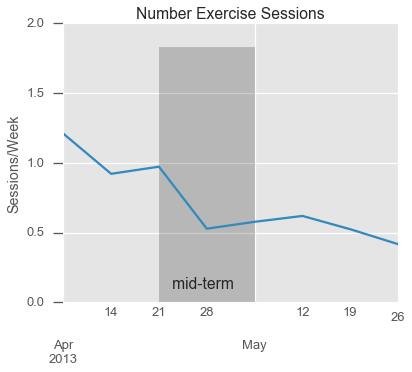

In [172]:
A = pd.DataFrame((Exercise_df['have']==1))
A['id'] = Exercise_df['id']
A = A.groupby('id').resample('W',how='sum').unstack(level=1).mean(axis=0)
A.reset_index(level=0,drop=True,inplace=True)







fig,ax = plt.subplots(figsize=(6,5))

A[:semester_end].plot(color=colors[1])

plt.title('Number Exercise Sessions')
plt.xlabel('')
plt.ylabel('Sessions/Week')

ax.fill_between([start,end],0,A.max()*1.1,facecolor='black', alpha = .2, interpolate=True)
ax.text(start, 0.1,'   mid-term')
sns.despine()

## Correlation among Exercise Measures

In [195]:
Exercise = pd.DataFrame(Exercise_Sessions_Total)
Exercise = Exercise.merge(pd.DataFrame(gym_sum),left_index=True,right_index=True,how='outer')
Exercise = Exercise.merge(pd.DataFrame(Activity_Totals['Running']),left_index=True,right_index=True,how='outer')
Exercise.rename(columns={0:'Self Report','gym':'Gym'},inplace=True)
Exercise.head()

,Self Report,Gym,Running
id,,,
u00,1.20,1.83,27.50
u01,0.00,0.00,28.50
u02,0.86,6.67,1.20
u03,0.20,0.00,1.56
u04,1.71,7.83,54.33


In [196]:
Exercise.corr()

,Self Report,Gym,Running
Self Report,1.00,0.33,-0.05
Gym,0.33,1.00,0.08
Running,-0.05,0.08,1.00


In [187]:
Activity_Totals

,Running,Stationary,Unknown,Walking
id,,,,
u00,27.50,1444.20,51.80,100.80
u01,28.50,1571.70,7.10,56.60
u02,1.20,1724.60,22.90,103.00
u03,1.56,1564.56,3.44,17.78
u04,54.33,1562.00,49.00,115.78
u05,3.20,1544.60,34.10,56.30
u07,18.75,1595.50,22.50,52.75
u08,22.60,1668.40,11.10,87.60
u09,7.90,1595.80,24.10,81.00


In [186]:
Activity_WA['Running']

id
u00    22.92
u01    23.75
u02     1.00
u03     1.17
u04    40.75
u05     2.67
u07    12.50
u08    18.83
u09     6.58
u10    11.42
u12    14.25
u13     8.67
u14     5.50
u15     0.92
u16     4.50
u17     4.50
u18     3.33
u19     0.75
u20     0.50
u22    16.42
u23     2.25
u24     6.08
u25     8.67
u27     2.92
u30     6.75
u31     5.00
u32     8.92
u33     4.50
u34     4.17
u35    12.75
u36    27.83
u39     0.00
u41     3.75
u42     2.17
u43     8.08
u44     1.50
u45     1.50
u46    31.67
u47     2.08
u49     3.17
u50     0.08
u51    26.42
u52   117.67
u53     1.25
u54     4.92
u56     9.08
u57    38.75
u58     6.67
u59    18.83
Name: Running, dtype: float64

In [182]:
gym_sum.shape

(49,)